In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates as mdates
import matplotlib.cm as cm
import numpy as np # for array processing
import pandas as pd 

from scipy.stats import norm
from scipy import stats
from scipy.stats import gaussian_kde

import datetime

#import folium
from IPython.display import HTML
from IPython.display import IFrame
import base64

from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.tools.eval_measures import rmse

from itertools import cycle, islice
#from mpld3 import save_html  #Installed from conda
#from folium import IFrame
#from mpl_toolkits.basemap import Basemap

In [2]:
from platform import python_version
#mport statsmodels.api as sm
#rint(sm.version())
print(python_version())
print(pd.__version__)

3.8.5
1.1.3


### Figures 1 and 2 
#### Read in uncleaned Data

In [3]:
#dfU=pd.read_excel('DataFiles/NYC_Tree_05_15_combined_09Oct19.xlsx')
dfU=pd.read_csv('DataFiles/PaperVersionUncleaned_05_15_combined.csv.gz')

/Users/bmaillou/anaconda3/envs/new_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
print ('original data size',dfU.shape)

original data size (773289, 99)


In [5]:
### remove a couple of unused solumns
dfU.drop(columns=['council district_15','state_15','st_assem_15', 'st_senate_15','community board_15','spc_latin_15','spc_latin_05'],inplace=True)

#### Calculate amount of growth
dfU.dropna(subset=['tree_dbh_05', 'tree_dbh_15'],inplace=True)
dfU['growth']=(dfU['tree_dbh_15']-dfU['tree_dbh_05'])
print('Data size for all trees with 2005 and 2015 data',dfU.shape)

Data size for all trees with 2005 and 2015 data (143192, 93)


In [6]:
dfU['tree_id_15']=dfU['tree_id_15'].astype(str).apply(lambda x: x.replace('.0',''))
dfU.set_index('tree_id_15',inplace=True)
dfU.index.rename('TreeID',inplace=True)

### Read in Cleaned NYC Data

In [7]:
dfC=pd.read_excel('DataFiles/Cleaned_NYC_Growth.xlsx')
#dfC=pd.read_excel('DataFiles/tree_census_join_20210613.xlsx') 

In [8]:
dfC['tree_id_15']=dfC['tree_id_15'].astype(str).apply(lambda x: x.replace('.0',''))
dfC.set_index('tree_id_15',inplace=True)
dfC.index.rename('TreeID',inplace=True)

## Read in Ground Truthed Data
* Read in Kobo Field data
* Combine with uncleaned NYC data
* Assess how many trees found
* calculate theil senn slope on the three data points

In [9]:
dfKobo=pd.read_excel('DataFiles/NYC Trees_V2 - latest.xlsx')
dfKobo.rename(columns={'What is the Tree ID? ': 'TreeID'}, inplace=True)
dfKobo.dropna(subset=['TreeID'],inplace=True)

temp=dfKobo['TreeID'].count()
print('number of trees visitied including duplicates={}'.format(temp))

dfKobo.TreeID=dfKobo.TreeID.astype(int)
dfKobo.TreeID=dfKobo.TreeID.astype(str)
dfKobo.set_index('TreeID',inplace=True)
#dfKobo.index=dfKobo.index.astype(str)

dfKobo.rename(columns={'DBH (cm) at breast height (Breast height is 4.5 ft/54 in/137 cm)':'DBH_cm',
       'DBH (in) at breast height (Breast height is 4.5 ft/54 in/137 cm)':'DBH_in',
       'Circumference (cm) at breast height (Breast height is 4.5 ft/54 in/137 cm)':'Circ_cm',
       'Circumference (in) at breast height (Breast height is 4.5 ft/54 in/137 cm)':'Circ_in'},inplace=True)

dfKobo['tree_dbh_19']=dfKobo.apply(lambda row: row.DBH_in if pd.notnull(row.DBH_in) else row.DBH_cm/2.54, axis=1)



dfKobo = dfKobo.loc[~dfKobo.index.duplicated(keep='first')]

print('number of trees visitied removing duplicates={}'.format(dfKobo.index.shape))

temp=dfKobo['tree_dbh_19'].count()
print('number of trees visitied and could be measured={}'.format(temp))


dfGT=pd.concat([dfKobo,dfU], axis=1,join='inner')

temp=dfGT.dropna(subset=['tree_dbh_05','tree_dbh_15'])['tree_dbh_05'].count()
print('number of trees with 2005 and 2015 numbers={}'.format(temp))


print('Trees that were not remeasured',dfGT[dfGT['tree_dbh_19'].isnull()].index)

dfGT=dfGT.dropna(subset=['tree_dbh_05','tree_dbh_15','tree_dbh_19'])

temp=dfGT['tree_dbh_05'].count()
print('number of trees with 2005, 20015, and 2019 numbers={}'.format(temp))



number of trees visitied including duplicates=104
number of trees visitied removing duplicates=(93,)
number of trees visitied and could be measured=87
number of trees with 2005 and 2015 numbers=92
Trees that were not remeasured Index(['98860', '193105', '193104', '76328', '90908', '89535'], dtype='object', name='TreeID')
number of trees with 2005, 20015, and 2019 numbers=86


### Summary of trees could not find

We tried to visit 93 trees.  We could not find 6 trees (reasons are below).  Then one tree we visited was missing NYC data so this brings us down to 92.  We found 86 trees that had 3 data points, two from NYC and the one we added.  In summary I will say we visited 91 trees with 2005 and 2015 data.  5 could not be re-located and measured and one was a data entry problem with pictures of the office so was never visited so I am calling in 91 visited.  

* 98860 - Found a tree with all branches cut off
* 193105 - Construction blocking it
* 193104 - Construction blocking it
* 76328 - could not find tree
* 90908 - could not find tree
* 89535 - Field Entry error.  No data and pictures of office

### Trees we found for Ground Truthing

In [10]:
df_GT_tree_growth=pd.DataFrame()
i=0
for index, row in dfGT.iterrows():

    
    x=np.array([2005,2015,2019.0])
    y=row[['tree_dbh_05','tree_dbh_15','tree_dbh_19']].astype(float)
        
    stats_theil=stats.theilslopes(y,x, alpha=0.95)
    stats_kendall= stats.kendalltau(y,x)
    df_GT_tree_growth.at[i,'treeid']=index
    df_GT_tree_growth.at[i,'spc_common']=row.spc_common
    df_GT_tree_growth.at[i,'slope']=stats_theil[0]
    df_GT_tree_growth.at[i,'kendalltau']=stats_kendall.correlation
    df_GT_tree_growth.at[i,'2015_2005']=y[1]-y[0]
    i+=1

#To print out ground_truthed data for each tree
#df_GT_tree_growth.to_excel('DataFiles/Ground_Truthed_Fitted_Data.xlsx')

temp=(df_GT_tree_growth['slope']>=0).count()
print('Number of Ground Truthed Trees={}'.format(temp))

temp=(df_GT_tree_growth['slope']>=0).value_counts()
print('Positive Slope={}, Negative slope={}'.format(temp[1],temp[0]))

temp=(df_GT_tree_growth['slope']>=0).value_counts()/df_GT_tree_growth['slope'].count()*100
print('% Positive Slope={}, % Negative slope={}'.format(temp[1],temp[0]))

temp=(df_GT_tree_growth['slope']< -0.5).value_counts()
print('Slope Less than -0.5 in/yr={}'.format(temp[1]))

temp=(df_GT_tree_growth['kendalltau']==1).value_counts()
print('Kendall Tau=1: {}'.format(temp[1]))
      
temp=(df_GT_tree_growth['2015_2005']>=0).value_counts()
print('NYC 2015-2005 >=0 ={},<0={} '.format(temp[1],temp[0]))

temp=(df_GT_tree_growth['2015_2005']< -5).value_counts()
print('NYC 2015-2005 < -5 ={}'.format(temp[1]))

temp=df_GT_tree_growth[np.logical_or(df_GT_tree_growth['2015_2005']<0
                                ,df_GT_tree_growth['slope']<0)].count()
print('\nTrees that have negative slope (theil senn slope) or 2015-2005={}'.format(temp))

Number of Ground Truthed Trees=86
Positive Slope=73, Negative slope=13
% Positive Slope=84.88372093023256, % Negative slope=15.11627906976744
Slope Less than -0.5 in/yr=3
Kendall Tau=1: 53
NYC 2015-2005 >=0 =72,<0=14 
NYC 2015-2005 < -5 =7

Trees that have negative slope (theil senn slope) or 2015-2005=treeid        15
spc_common    15
slope         15
kendalltau    15
2015_2005     15
dtype: int64


In [11]:
df_GT_tree_growth['slope'].describe()

count    86.000000
mean      0.122961
std       0.424945
min      -3.022497
25%       0.100893
50%       0.178571
75%       0.288526
max       0.641732
Name: slope, dtype: float64

### All trees with a negative slope or negative 2015-2005

In [12]:
df_GT_tree_growth[np.logical_or(df_GT_tree_growth['2015_2005']<0
                                ,df_GT_tree_growth['slope']<0)].sort_values(by='2015_2005')

,treeid,spc_common,slope,kendalltau,2015_2005
25,193097,london planetree,-3.022497,-0.333333,-43.0
48,344045,ginkgo,-0.896429,-0.333333,-14.0
39,76486,ginkgo,0.035714,0.333333,-9.0
28,76334,callery pear,-0.528571,-0.333333,-8.0
42,349446,ginkgo,-0.257143,-0.333333,-6.0
49,344049,callery pear,-0.364286,-0.333333,-6.0
64,261813,ginkgo,-0.359286,-0.333333,-6.0
43,349468,ginkgo,-0.271429,-0.333333,-4.0
27,76656,london planetree,-0.171429,-0.333333,-3.0
33,76059,callery pear,-0.207143,-0.333333,-3.0


Now I went back and looked at each tree to see what happened

Seven trees decreased by over 5 inches in the two NYC surveys.  The three DBH numbers are the 2005 NYC,2015 NYC, and 2019 ground truth data
* 193097	london planetree -43.0=52,9,9.7 definately a small london must have been replaced
* 344045	ginkgo -14.0= 16,2,3.45small gingko planted next to big ginkgo.  Could be replanted or wrong tree.  second two data points match.
* 76486	ginkgo -9.0= 10,1,10.5. Was a big gingko in pictures. 3 data points are   Probably a typo in 2015 data 
* 76334	callery pear -8.0=10,2,2.6. replaced-a new tree.  Tree has Tag on it.
* 349446	ginkgo -6.0=8,2,4.4looks like new tree with tag on it
* 344049	callery pear -6.0=10,4,4.9. smaller tree.  could have been replaced.  second two measurements match
* 261813	ginkgo -6.0=19,13,13.97.  Tree is big in its own pit.  Assuming first one is a mistake/typo

Summary for the 7 trees appears to be 5 trees were replaced with the same species, one appears to be a typo in 2015 NYC data, and one is a mismeasurement or typo in 2005 NYC data


Eight more trees had a negative kendall tau slope or decreased from 2005 to 2015 but less than 5 inches.

* 349468	ginkgo -4.0=13,9,9.2. we visited in twice and got 9.2 and 9.28.  2005=13, 2015=9.  Too big to be replaced.  must be measurement error
* 76656	london planetree -3.0=7,4,4.6. a small scraggly tree behind scaffolding. Maybe replaced or mismeasure the first time
* 76059	callery pear -3.0=11,8,8.2.  behind scaffolding. Probably miss measured the first time 
* 344063	honeylocust -3.0=9,6,6.7.  nothing special.  looks okay on pictures.  Probably mis-measured the first time.
* 255391	ginkgo -3.0=5,2,3.8, looks like okay in pictures.  Either replaced or mismeasured
* 329103	ginkgo -2.0=8,6,6.5 looks okay in pictures.  Rounding errors on NYC data
* 155515	ginkgo -2.0=10,8,13.2 looks okay in pictures.  8 must be a mismeasurement
* 39446	littleleaf linden 1.0=10,11,4.55.  Has a tag probably a new tree.  


In [13]:
### This is just used to get data for a specific tree
dfGT.loc['76516'][['tree_dbh_05','tree_dbh_15','tree_dbh_19']]

tree_dbh_05        8
tree_dbh_15       10
tree_dbh_19    10.73
Name: 76516, dtype: object

### Temporal Validation data.
Was originally called "campus tree data 2015 2016 2017 terryanne.xlsx"

These are trees that were visited annually from 2015 or 2016 onward.

In [14]:
dfTV=pd.read_excel('DataFiles/TemporalValidationData.xlsx'
                   ,sheet_name='Terryanne',index_col='old tree number')
dfTV.index=dfTV.index.astype(str)
dfTV['NYCtree_id']=dfTV['NYCtree_id'].astype(str).apply(lambda x: x.replace('.0',''))


temp=(dfTV['UseMe'].count())
print('the full number of campus trees measured was {}'.format(temp))

dfTV=dfTV[dfTV['UseMe']==True]

print('the shape of the Temporal Validation data is {}'.format(dfTV.shape))

temp=(dfTV['DBH_15']>0).value_counts()
print('Number of trees with NYC data from 2015={}'.format(temp[1]))

temp=(dfTV['DBH_05']>0).value_counts()
print('Number of trees with NYC data from 2005={}'.format(temp[1]))

temp=(np.logical_and(dfTV['DBH_05']>0,dfTV['DBH_15']>0)).value_counts()
print('Number of trees with NYC data from 2005 and 2015={}'.format(temp[1]))



the full number of campus trees measured was 73
the shape of the Temporal Validation data is (44, 24)
Number of trees with NYC data from 2015=36
Number of trees with NYC data from 2005=1
Number of trees with NYC data from 2005 and 2015=1


Over the years 73 trees have been measured for temporal validation but for many trees they either didn't have data from 2015 or 2016 or were subsequently removed.  There has been a lot of construction around campus.  For this analysis only trees that had measurments begining in 2015 or 2016 and went to 2021 were used. This gave us 44 trees that could be used for the analysis.  Out of these 44, 36 trees had data from the 2015 NYC census and 1 of the 36 trees also had a datapoint from the 2005 NYC tree census.

In [15]:
dfTV_summary=pd.DataFrame()

for i,tree_all in dfTV.iterrows():
    tree=tree_all[[datetime.datetime(2015, 11, 1, 0, 0),
       datetime.datetime(2016, 11, 1, 0, 0),
       datetime.datetime(2017, 11, 1, 0, 0),
       datetime.datetime(2018, 11, 18, 0, 0),
       datetime.datetime(2019, 7, 1, 0, 0),
       datetime.datetime(2020, 11, 19, 0, 0),
       datetime.datetime(2021, 4, 21, 0, 0),
       datetime.datetime(2021, 6, 10, 0, 0),
       datetime.datetime(2021, 6, 21, 0, 0)]]

    x=tree.dropna().index.year+ (tree.dropna().index.dayofyear -1)/365  #convert to decimal year
    y=tree.dropna().values
    if x.shape[0]>1:

        stats_theil=stats.theilslopes(y,(x-x[0]), alpha=0.95)
        stats_kendall= stats.kendalltau(y,(x-x[0]))
        dfTV_summary.at[i,'old tree number']=i
        dfTV_summary.at[i,'new tree number']=tree_all['new tree number']
        dfTV_summary.at[i,'NYCtree_id']=tree_all['NYCtree_id']
        dfTV_summary.at[i,'species']=tree_all['species']
        dfTV_summary.at[i,'slope']=stats_theil[0]
        dfTV_summary.at[i,'kendalltau']=stats_kendall.correlation
        dfTV_summary.at[i,'count']=len(y)
        dfTV_summary.at[i,'start']=x.min()
        dfTV_summary.at[i,'stop']=x.max()
    else:
        print('no data for tree',i)


In [16]:
dfTV_summary

,old tree number,new tree number,NYCtree_id,species,slope,kendalltau,count,start,stop
1,1,trees on BWAY,338579,pin oak,0.179980,1.000000,7.0,2015.832877,2021.301370
2,2,starting on corner,338578,red oak,0.274299,0.714286,7.0,2015.832877,2021.301370
3,3,of BWAY & 120,338577,red oak,0.240000,0.904762,7.0,2015.832877,2021.301370
4,4,NaN,338576,red oak,0.261280,1.000000,7.0,2015.832877,2021.301370
5,5,NaN,338575,elm,0.400476,1.000000,7.0,2015.832877,2021.301370
6,6,NaN,338574,red oak,0.273894,0.904762,7.0,2015.832877,2021.301370
7,7,NaN,338573,London Plane,0.354760,1.000000,7.0,2015.832877,2021.301370
8,8,NaN,338572,London Plane,0.280000,1.000000,7.0,2015.832877,2021.301370
9,9,NaN,338571,London Plane,0.325501,1.000000,7.0,2015.832877,2021.301370
10,10,NaN,338570,London Plane,0.358417,1.000000,7.0,2015.832877,2021.301370


In [17]:
dfTV_summary['count'].describe()

count    44.000000
mean      6.863636
std       0.667899
min       5.000000
25%       6.750000
50%       7.000000
75%       7.000000
max       8.000000
Name: count, dtype: float64

In [18]:
temp=(dfTV_summary['slope']>=0).value_counts()
if temp[1]==dfTV_summary['slope'].count():
    print('no trees with negative slopes')
else:
    print('trouble')


no trees with negative slopes


In [19]:
temp=(dfTV_summary['kendalltau']>=.99999).value_counts()
print('Kendall Tau=1 = {}, less than 1= {}'.format(temp[1],temp[0]))
## I am assuming a rounding error in numpy to not get 1.  

temp=(dfTV_summary['kendalltau']>=.99999).value_counts()/dfTV_summary['kendalltau'].count()*100
print('% Kendall Tau=1 = {}, %less than 1= {}'.format(temp[1],temp[0]))

Kendall Tau=1 = 28, less than 1= 16
% Kendall Tau=1 = 63.63636363636363, %less than 1= 36.36363636363637


## Figure 2
Uses data from
* NYC Cleaned data
* Ground Truthed fitted data using three points
* Temporal Validation data

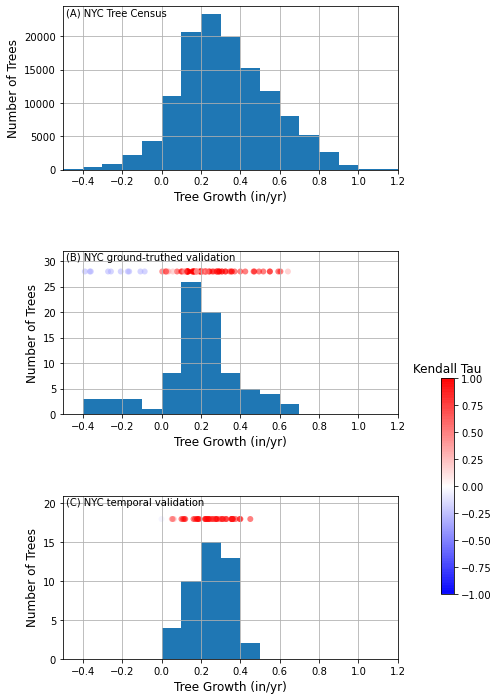

In [24]:
fig,ax=plt.subplots(3,1)
fig.set_size_inches(6,12)

#####################################
bins=np.linspace(-1.1,1.2,24)
################################
ax[1].hist(df_GT_tree_growth.slope,bins=bins)#
ax[1].set_xlabel('Tree Growth (in/yr)',fontsize=12)
ax[1].set_ylabel('Number of Trees',fontsize=12)
df_GT_tree_growth['temp_y']=28
im=ax[1].scatter(df_GT_tree_growth.slope,df_GT_tree_growth.temp_y,c=df_GT_tree_growth.kendalltau,alpha=0.5,cmap='bwr',edgecolor='none',vmin=-1)
ax[1].text(0.01,.99,'(B) NYC ground-truthed validation',transform=ax[1].transAxes,fontsize=10,verticalalignment='top')#,bbox=props2)
ax[1].set_xlim(-.5,1.2)
ax[1].set_ylim(0,32)
cbaxes = fig.add_axes([1.0, 0.2, 0.03, 0.25]) 
cbar=fig.colorbar(im,shrink=0.1,cax=cbaxes)#,ax=axbig
cbar.ax.set_title('Kendall Tau')
cbar.solids.set_edgecolor("face")
ax[1].grid()

###############################################################################
dfTV_summary.slope.hist(ax=ax[2],bins=bins)
ax[2].set_xlabel('Tree Growth (in/yr)',fontsize=12)
ax[2].set_ylabel('Number of Trees',fontsize=12)
dfTV_summary['temp_y']=18
im=ax[2].scatter(dfTV_summary.slope,dfTV_summary.temp_y,c=dfTV_summary.kendalltau,alpha=0.5,cmap='bwr',edgecolor='none',vmin=-1)
ax[2].text(0.01,.99,'(C) NYC temporal validation',transform=ax[2].transAxes,fontsize=10,verticalalignment='top')#,bbox=props2)
ax[2].set_xlim(-.5,1.2)
ax[2].set_ylim(0,21)

##########################################################
dfC['growth_rate'].hist(ax=ax[0],bins=bins)
ax[0].set_xlim(-.5,1.2)
ax[0].set_xlabel('Tree Growth (in/yr)',fontsize=12)
ax[0].set_ylabel('Number of Trees',fontsize=12)
ax[0].text(0.01,.99,'(A) NYC Tree Census',transform=ax[0].transAxes,fontsize=10,verticalalignment='top')#,bbox=props2)

fig.subplots_adjust(wspace=.5,hspace=.5)
fig.savefig('Figures/Figure2-Histograms_of_Datasets.tif',dpi=600,bbox_inches='tight')

## Figure 3
* This used NYC uncleaned data since using cleaned data would have removed the trees in panel (B) that is used as an example of a tree being removed

ground truth pos growth n=72, neg growth n=7, discard n=7
temporal pos growth n=44, neg growth n=0


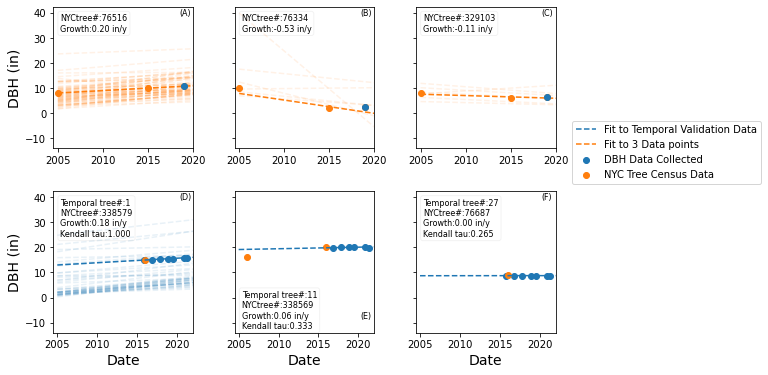

In [23]:
props=dict(boxstyle='round',facecolor='white',alpha=.05)

fig,ax=plt.subplots(2,3,sharey=True)
fig.set_size_inches(9,6)

treeNum='76516'
ax[0,0].scatter(2019.0,dfGT.loc[treeNum]['tree_dbh_19'],zorder=10)
x=np.array([2005,2015,2019])
y=dfGT.loc[treeNum][['tree_dbh_05','tree_dbh_15','tree_dbh_19']].astype(float)

ax[0,0].scatter(x,y)
stats_theil=stats.mstats.theilslopes(y,x, alpha=0.95)
textstr='NYCtree#:{}\nGrowth:{:0.2f} in/y'.format(treeNum,stats_theil[0])
ax[0,0].text(0.05,0.95,textstr,transform=ax[0,0].transAxes,fontsize=8,verticalalignment='top',bbox=props)
ax[0,0].text(0.90,.99,'(A)',transform=ax[0,0].transAxes,fontsize=8,verticalalignment='top')#,bbox=props2)
ax[0,0].set_ylabel('DBH (in)',fontsize=14)
ax[0,0].set_xlim([2004.5,2020])
intercept=np.median(y)-stats_theil[0]*np.median(x)
tempx=np.linspace(2005,2021)
ax[0,0].plot(tempx,stats_theil[0]*tempx+intercept,zorder=1,c='C1',linestyle='dashed')


treeNum='76334'
ax[0,1].scatter(2019.0,dfGT.loc[treeNum]['tree_dbh_19'],zorder=10)
x=np.array([2005,2015,2019])
y=dfGT.loc[treeNum][['tree_dbh_05','tree_dbh_15','tree_dbh_19']].astype(float)
ax[0,1].scatter(x,y)

stats_theil=stats.mstats.theilslopes(y,x, alpha=0.95)
textstr='NYCtree#:{}\nGrowth:{:0.2f} in/y'.format(treeNum,stats_theil[0])
ax[0,1].text(0.05,0.95,textstr,transform=ax[0,1].transAxes,fontsize=8,verticalalignment='top',bbox=props)
ax[0,1].text(0.90,.99,'(B)',transform=ax[0,1].transAxes,fontsize=8,verticalalignment='top')#,bbox=props2)
ax[0,1].set_xlim([2004.5,2020])
intercept=np.median(y)-stats_theil[0]*np.median(x)
tempx=np.linspace(2005,2021)
ax[0,1].plot(tempx,stats_theil[0]*tempx+intercept,zorder=1,c='C1',linestyle='dashed')


##############################################
treeNum='329103'
ax[0,2].scatter(2019.0,dfGT.loc[treeNum]['tree_dbh_19'],zorder=10)
x=np.array([2005,2015,2019])
y=dfGT.loc[treeNum][['tree_dbh_05','tree_dbh_15','tree_dbh_19']].astype(float)
ax[0,2].scatter(x,y)
stats_theil=stats.mstats.theilslopes(y,x, alpha=0.95)
textstr='NYCtree#:{}\nGrowth:{:0.2f} in/y'.format(treeNum,stats_theil[0])
ax[0,2].text(0.05,0.95,textstr,transform=ax[0,2].transAxes,fontsize=8,verticalalignment='top',bbox=props)
ax[0,2].text(0.90,.99,'(C)',transform=ax[0,2].transAxes,fontsize=8,verticalalignment='top')#,bbox=props2)
ax[0,2].set_xlim([2004.5,2020])
intercept=np.median(y)-stats_theil[0]*np.median(x)
tempx=np.linspace(2005,2021)
ax[0,2].plot(tempx,stats_theil[0]*tempx+intercept,zorder=1,c='C1',linestyle='dashed',label='Best fit NYC Data')



#####################################################################
##############I used iloc to ignore early columns.  So if a column gets added it needs to change
######## I hardwired teh columns needed
treeNum='1'
x=pd.to_datetime(dfTV.loc[treeNum].iloc[7:14].dropna().index).year \
 + (pd.to_datetime(dfTV.loc[treeNum].iloc[7:14].dropna().index).dayofyear -1)/365

y=dfTV.loc[treeNum].iloc[7:14].dropna().values
ax[1,0].scatter(x,y)
ax[1,0].scatter([2006,2016],dfTV.loc[treeNum][['DBH_05','DBH_15']])

stats_theil=stats.mstats.theilslopes(y,x, alpha=0.95)
stats_kendall= stats.kendalltau(y,x)
textstr='Temporal tree#:1\nNYCtree#:{}\nGrowth:{:0.2f} in/y\nKendall tau:{:0.3f}'.format(dfTV.loc[treeNum]['NYCtree_id']
                                                                                        ,stats_theil[0],stats_kendall.correlation)
ax[1,0].text(0.05,0.95,textstr,transform=ax[1,0].transAxes,fontsize=8,verticalalignment='top',bbox=props)
ax[1,0].text(0.90,.99,'(D)',transform=ax[1,0].transAxes,fontsize=8,verticalalignment='top')#,bbox=props2)
ax[1,0].set_xlabel('Date',fontsize=14)
ax[1,0].set_ylabel('DBH (in)',fontsize=14)
ax[1,0].set_xlim([2004.5,2022])
intercept=np.median(y)-stats_theil[0]*np.median(x)
tempx=np.linspace(2005,2022)
ax[1,0].plot(tempx,stats_theil[0]*tempx+intercept,zorder=1,c='C0',linestyle='dashed')



################################################################
treeNum='11'
x=pd.to_datetime(dfTV.loc[treeNum].iloc[7:14].dropna().index).year \
 + (pd.to_datetime(dfTV.loc[treeNum].iloc[7:14].dropna().index).dayofyear -1)/365

y=dfTV.loc[treeNum].iloc[7:14].dropna().values
ax[1,1].scatter(x,y)
ax[1,1].scatter([2006,2016],dfTV.loc[treeNum][['DBH_05','DBH_15']])

stats_theil=stats.mstats.theilslopes(y,x, alpha=0.95)
stats_kendall= stats.kendalltau(y,x)
textstr='Temporal tree#:11\nNYCtree#:{}\nGrowth:{:0.2f} in/y\nKendall tau:{:0.3f}'.format(dfTV.loc[treeNum]['NYCtree_id']
                                                                                          ,stats_theil[0],stats_kendall.correlation)
ax[1,1].text(0.05,0.3,textstr,transform=ax[1,1].transAxes,fontsize=8,verticalalignment='top',bbox=props)
ax[1,1].text(0.90,.15,'(E)',transform=ax[1,1].transAxes,fontsize=8,verticalalignment='top')#,bbox=props2)
ax[1,1].set_xlabel('Date',fontsize=14)
ax[1,1].set_xlim([2004.5,2022])
intercept=np.median(y)-stats_theil[0]*np.median(x)
tempx=np.linspace(2005,2022)
ax[1,1].plot(tempx,stats_theil[0]*tempx+intercept,zorder=1,c='C0',linestyle='dashed')


##################################################
treeNum='27'
x=pd.to_datetime(dfTV.loc[treeNum].iloc[7:14].dropna().index).year \
 + (pd.to_datetime(dfTV.loc[treeNum].iloc[7:14].dropna().index).dayofyear -1)/365

y=dfTV.loc[treeNum].iloc[7:14].dropna().values
ax[1,2].scatter(x,y,label='DBH Data Collected')
ax[1,2].scatter([2006,2016],dfTV.loc[treeNum][['DBH_05','DBH_15']],label='NYC Tree Census Data')

stats_theil=stats.mstats.theilslopes(y,x, alpha=0.95)
stats_kendall= stats.kendalltau(y,x)
textstr='Temporal tree#:27\nNYCtree#:{}\nGrowth:{:0.2f} in/y\nKendall tau:{:0.3f}'.format(dfTV.loc[treeNum]['NYCtree_id']
                                                                                          ,stats_theil[0],stats_kendall.correlation)
ax[1,2].text(0.05,0.95,textstr,transform=ax[1,2].transAxes,fontsize=8,verticalalignment='top',bbox=props)
ax[1,2].text(0.90,.99,'(F)',transform=ax[1,2].transAxes,fontsize=8,verticalalignment='top')#,bbox=props2)
ax[1,2].set_xlabel('Date',fontsize=14)
ax[1,2].set_xlim([2004.5,2022])

intercept=np.median(y)-stats_theil[0]*np.median(x)
tempx=np.linspace(2005,2022)
ax[1,2].plot(tempx,stats_theil[0]*tempx+intercept,zorder=1,c='C0',linestyle='dashed',label='Fit to Temporal Validation Data')

ax[1,2].plot(0,0,zorder=1,c='C1',linestyle='dashed',label='Fit to 3 Data points')

ax[1,2].legend(loc=[1.12,1.05])


####################
######## add the lines
x=np.array([2005,2015,2019])
tempx=np.array([2005,2022])
count_plus=0
count_neg=0
count_disc=0
for idx,dfr in dfGT.iterrows():
    y=dfr[['tree_dbh_05','tree_dbh_15','tree_dbh_19']]
    stats_theil=stats.mstats.theilslopes(y,x, alpha=0.95)
    intercept=np.median(y)-stats_theil[0]*np.median(x)
    if dfr['tree_dbh_15']-dfr['tree_dbh_05']>=0:#stats_theil[0]>=0:
        plot=ax[0][0].plot(tempx,stats_theil[0]*tempx+intercept,zorder=1,linestyle='dashed',color='C1',alpha=0.1)
        count_plus+=1
    elif dfr['tree_dbh_15']-dfr['tree_dbh_05']<-5.:#stats_theil[0]<-0.5:
        plot=ax[0][1].plot(tempx,stats_theil[0]*tempx+intercept,zorder=1,linestyle='dashed',color='C1',alpha=0.1)
        count_disc+=1
    else:# stats_theil[0]<0:
        plot=ax[0][2].plot(tempx,stats_theil[0]*tempx+intercept,zorder=1,linestyle='dashed',color='C1',alpha=0.1)
        count_neg+=1
print('ground truth pos growth n={}, neg growth n={}, discard n={}'.format(count_plus
                                                                           ,count_neg
                                                                          ,count_disc))
##################
######### add lines for temporal
count_plus=0
count_neg=0
for idx,dfR in dfTV.iterrows():
    temp=dfR.iloc[7:14].dropna()
    
    x=pd.to_datetime(temp.index).year \
 + (pd.to_datetime(temp.index).dayofyear -1)/365
    y=temp.values
    stats_theil=stats.mstats.theilslopes(y,x, alpha=0.95)
    intercept=np.median(y)-stats_theil[0]*np.median(x)
    if stats_theil[0]>0:
        plot=ax[1][0].plot(tempx,stats_theil[0]*tempx+intercept,zorder=1
                           ,linestyle='dashed',color='C0',alpha=0.1)
        count_plus+=1
    if stats_theil[0]<=0:
        plot=ax[1][2].plot(tempx,stats_theil[0]*tempx+intercept,zorder=1
                           ,linestyle='dashed',color='C0',alpha=0.1)
        count_neg+=1
print('temporal pos growth n={}, neg growth n={}'.format(count_plus,count_neg))


fig.subplots_adjust(wspace=.3,hspace=.3)
fig.savefig('Figures/Figure3-NYC_Barnard_example_trees_all_data.tif',dpi=400,bbox_inches='tight')

Double Check zip codes used

In [22]:
dfGT['What is the Zip code from the NYC Tree survey?'].value_counts()

10025.0    53
10027.0    27
10024.0     6
Name: What is the Zip code from the NYC Tree survey?, dtype: int64

# END